In [1]:
import numpy as np
import pandas as pd
import pygmo
import sys
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
 
%matplotlib inline

In [2]:
n_prod = 5
n_customer = 1000000

from config import MAX_DISCOUNT

In [3]:
n_customer_predictors=2
n_product_predictors=0

customer_predictors = ['x_c%d'%i for i in range(n_customer_predictors)]
product_predictors = ['x_p%d'%i for i in range(n_product_predictors)]

In [4]:
np.random.seed(123456)
df_prod = pd.DataFrame(np.random.rand(n_prod, n_product_predictors), columns = product_predictors)
df_prod.loc[:, 'Elasticity'] = np.random.rand(n_prod)
df_prod.loc[:, 'RRP'] = np.arange(900, 2600, 400) - 1 #((np.random.rand(n_prod)+.2)*2e3).round(-2)
df_prod.loc[:, 'Service'] = (np.random.rand(n_prod) * 0.7 * df_prod['RRP']).round(-1)
df_prod.loc[:, 'Cost'] = ((np.random.rand(n_prod) * 0.3 + 0.2)* df_prod['RRP']).round(-1)

df_prod

,Elasticity,RRP,Service,Cost
0,0.126970,899,210.0,280.0
1,0.966718,1299,410.0,430.0
2,0.260476,1699,1000.0,410.0
3,0.897237,2099,180.0,960.0
4,0.376750,2499,950.0,1110.0


In [5]:
min_Price = df_prod['RRP'].min()*0.9
max_Price = df_prod['RRP'].max()*1.1

# df_customer = pd.DataFrame(np.random.rand(n_customer, n_customer_predictors), columns = customer_predictors)
# df_customer = pd.DataFrame(np.ones((n_customer, n_customer_predictors)), columns = customer_predictors)
df_customer = pd.DataFrame(np.clip(np.random.randn(n_customer, n_customer_predictors)*0.1+0.5, 0., 1.), columns = customer_predictors)

df_customer.loc[:, 'nPurchases']= (24*(np.random.rand(n_customer)**3)).round()
df_customer.loc[:, 'AvgPrice']= (min_Price + (max_Price-min_Price)*np.random.rand(n_customer)).round(-1)
df_customer.loc[:, 'AvgService']= (np.random.rand(n_customer) * 0.7 * df_customer['AvgPrice']).round(-1)
df_customer.loc[:, 'nPurchasesDiscount']= (np.random.rand(n_customer)*df_customer['nPurchases']).round()
df_customer.loc[:, 'AvgDiscount']= ((np.random.randn(n_customer)*0.2+1)*0.5*MAX_DISCOUNT*df_customer['AvgPrice']).round()
df_customer.loc[:, 'CLV']=((np.random.randn(n_customer)*0.1+1)* df_customer.eval('sqrt(nPurchases+10)*(AvgPrice+AvgService)')).round(-2)

print(df_customer.shape)
df_customer.describe()


(1000000, 8)


,x_c0,x_c1,nPurchases,AvgPrice,AvgService,nPurchasesDiscount,AvgDiscount,CLV
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.500164,0.500089,5.975117,1778.012160,622.079080,2.986556,355.450543,9399.724900
std,0.099952,0.099926,6.823650,559.776399,425.079767,4.313627,134.410251,4018.894607
min,0.019072,0.041169,0.000000,810.000000,0.000000,0.000000,-36.000000,2000.000000
25%,0.432725,0.432710,0.000000,1290.000000,280.000000,0.000000,247.000000,6300.000000
50%,0.500192,0.500069,3.000000,1780.000000,550.000000,1.000000,342.000000,8800.000000
75%,0.567540,0.567491,10.000000,2260.000000,900.000000,4.000000,449.000000,11700.000000
max,0.956460,0.954523,24.000000,2750.000000,1920.000000,24.000000,991.000000,33800.000000


In [6]:
df_prod.loc[:, 'product_id']=df_prod.index
df_customer.loc[:, 'customer_id']=df_customer.index
df_customer.loc[:, 'product_id']= np.random.randint(0, len(df_prod), len(df_customer))

df = pd.merge(df_customer, df_prod, on='product_id').sort_values('customer_id')

In [15]:
df['D_Scale_act'].describe()

count    1000000.000000
mean           0.173335
std            0.101205
min            0.000000
25%            0.086633
50%            0.172148
75%            0.258419
max            0.395557
Name: D_Scale_act, dtype: float64

In [7]:
def calculate_prob(df, discount_values):
    df.loc[:, 'BaseProb'] =  df.eval('x_c0*exp(-(((AvgPrice-RRP)/1./AvgPrice)**2))')  # x_c0: customer base scale
    df.loc[:, 'D_Scale_exp'] = df.eval('AvgDiscount/(AvgPrice + x_c1 * AvgService )') # x_c1: customer weight of service price
    df.loc[:, 'D_Scale_act'] = df.eval('({})/(RRP + x_c1 * Service )'.format(discount_values))
    df.loc[:, 'D_Freq'] = df.eval('(nPurchasesDiscount+0.3)/(nPurchases+1)')
    df.loc[:, 'DiscountEffect'] = df.eval('D_Freq*(1+ 10.*Elasticity*D_Scale_act + tanh((D_Scale_act-D_Scale_exp)*50))')
    df.loc[:, 'Probability'] =  df.eval('tanh(BaseProb * (1 + DiscountEffect))')

In [8]:
cols_grpby = ['product_id']
scan_propensity = []
scan_revenue = []
scan_profit = []
v_space = 0.01
for f in np.arange(0, MAX_DISCOUNT+v_space, v_space):
    calculate_prob(df, '{}*RRP'.format(f))
    s_prop = df.groupby(cols_grpby).apply(lambda df: np.mean(df['Probability'])).rename(f)
    s_reve = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP']*(1-f), df['Probability'])).rename(f)
    s_prof = df.groupby(cols_grpby).apply(lambda df: np.dot(df['RRP']*(1-f) - df['Cost'], df['Probability'])).rename(f)
    
    scan_propensity.append(s_prop)
    scan_revenue.append(s_reve)
    scan_profit.append(s_prof)

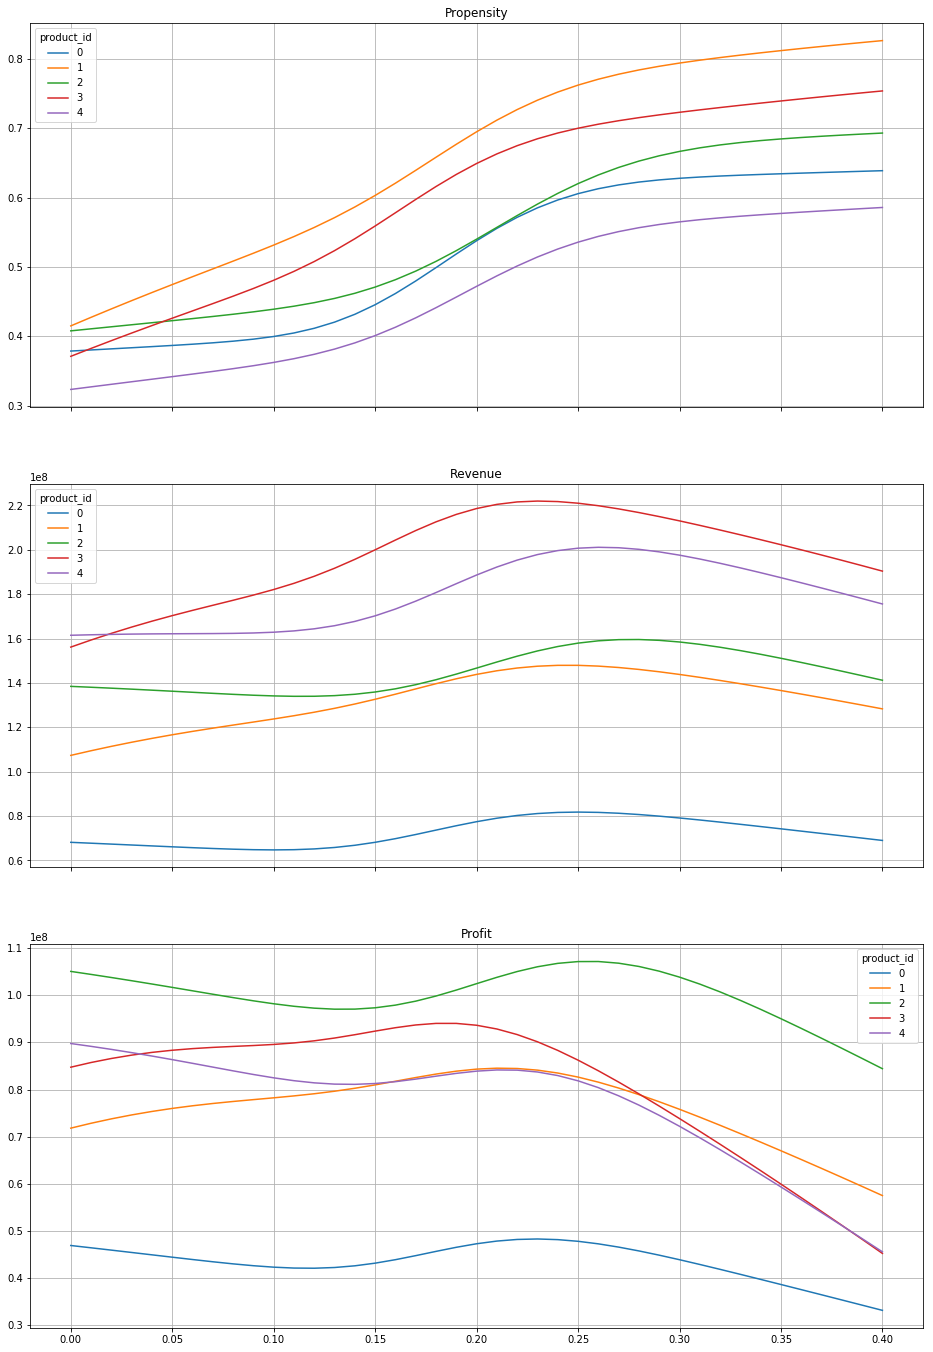

In [9]:
f, ax = plt.subplots(3, 1, figsize=(16,18), sharex=True)
pd.concat(scan_propensity, axis=1).T.plot(ax = ax[0],  title='Propensity', grid=True)
pd.concat(scan_revenue, axis=1).T.plot(ax = ax[1],  title='Revenue', grid=True)
pd.concat(scan_profit, axis=1).T.plot(ax = ax[2],  title='Profit', grid=True)

In [10]:
df.loc[:, 'Discount'] = (df['RRP']*np.random.rand(len(df))*MAX_DISCOUNT).round(-1)
calculate_prob(df, 'Discount')
df.loc[:, 'is_deal'] = (np.random.rand(len(df)) < df['Probability']).astype(int) 

In [11]:
df.groupby('product_id')['Probability'].describe()

,count,mean,std,min,25%,50%,75%,max
product_id,,,,,,,,
0,200342.0,0.517984,0.168309,0.046477,0.387011,0.489222,0.635641,0.989398
1,199229.0,0.662659,0.191924,0.098824,0.504716,0.651576,0.827254,0.999799
2,199901.0,0.549356,0.180326,0.034787,0.423843,0.525839,0.673405,0.993657
3,200565.0,0.605010,0.246523,0.019551,0.436811,0.609991,0.813291,0.999824
4,199963.0,0.463531,0.254806,0.003040,0.276908,0.475471,0.646044,0.996239


In [12]:
col_models = ['Probability'] # ,'BaseProb','DiscountEffect', ]
col_grby = ['product_id','Discount']

In [13]:
df[col_models].describe(np.arange(0, 1., 0.2))

,Probability
count,1000000.000000
mean,0.559645
std,0.222326
min,0.003040
0%,0.003040
20%,0.379912
40%,0.491664
50%,0.544919
60.0%,0.606530
80%,0.772041


In [14]:
df.to_csv('training_data_randn.csv', index=False)